<center> <h1>Numerical Methods  -- Assignment 7</h1> </center>

## Problem 1 -- Numerical integration

Numerical integration of an ODE
$$\frac{dy}{dt} = ry(1-y), \ where \ r = 0.01$$
with boundary conditions $y(0) = 10^{-5}$ for $0\leq t \leq 2000$.

First, we solve this ODE analytically
\begin{align*}
\frac{dy}{dt} &= 0.01 y(1-y) \\
100\frac{dy}{y(1-y)} &= dt\\
100\int \left(\frac{dy}{y}+\frac{dy}{1-y}\right) &=\int dt\\
\int \left(\frac{dy}{y}-\frac{d(1-y)}{1-y}\right) &=\int dt\\
100\,ln\left(\frac{y}{1-y}\right)+C &=t\\
\end{align*}
where $C$ is a constant. Now apply the boundary conditions, with $t_0=0$ and $y_0 = 0$
\begin{align*}
t &= 100\left[ln\left(\frac{y}{1-y}\right)+ln\left(\frac{10^{-5}}{1-10^{-5}}\right)\right]\\
\frac{t}{100} &= -ln(y^{-1}-1)+ln(10^5-1)\\
y^{-1}-1 &= (10^5-1)e^{-\frac{t}{100}}\\
y &= 1/\left[(10^5-1)e^{-100/t}+1\right]
\end{align*}
is the theoretical solution.

### Runge-Kutta 4$^{th}$ order method

### (a) Fixed step size

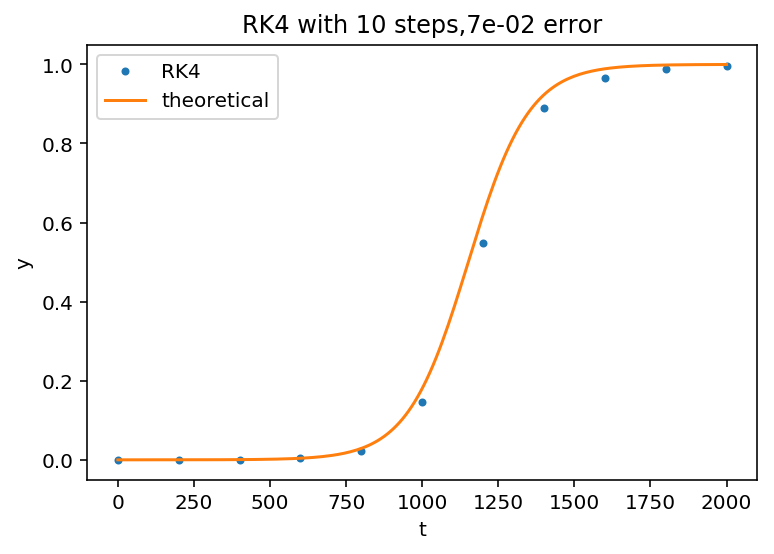

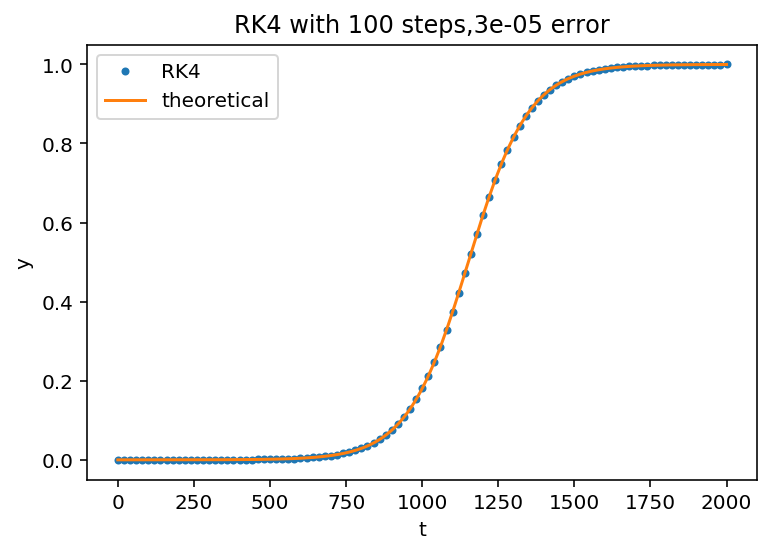

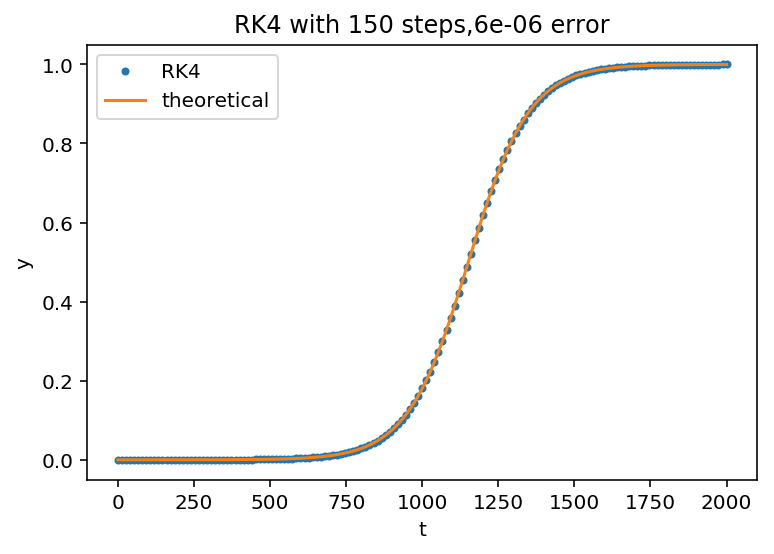

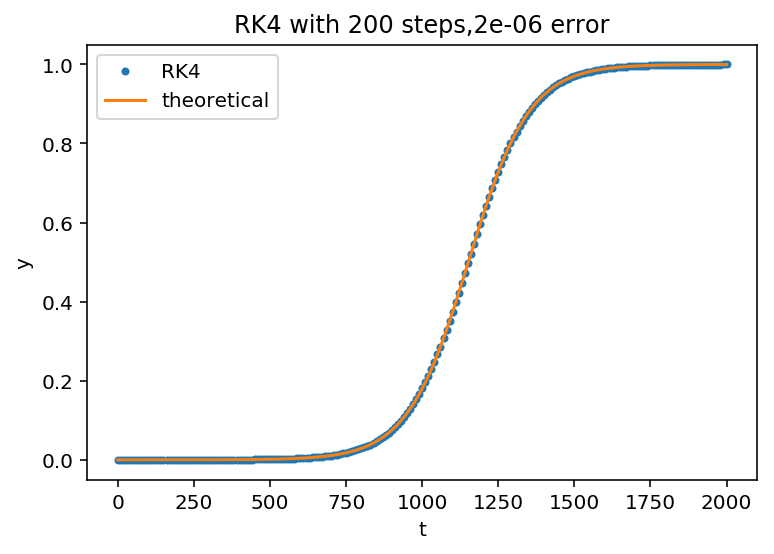

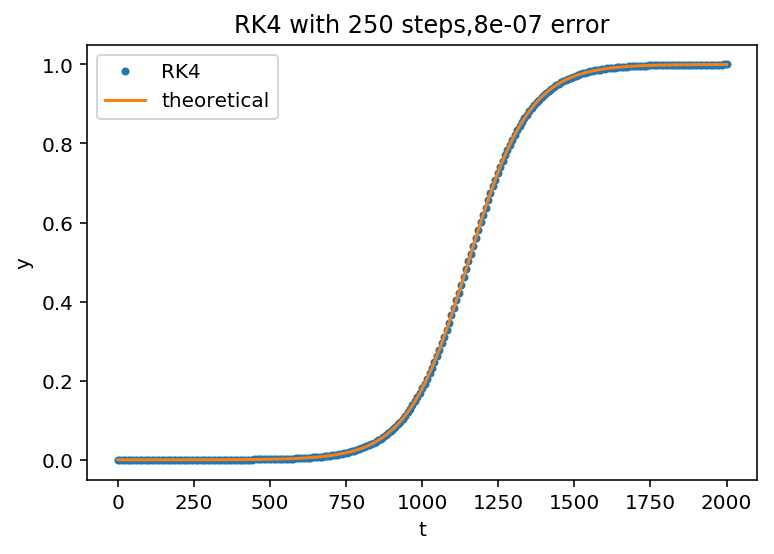

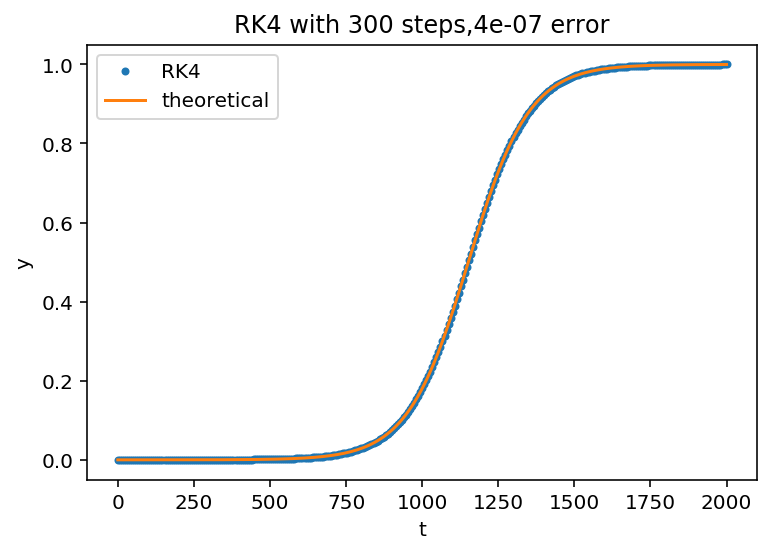

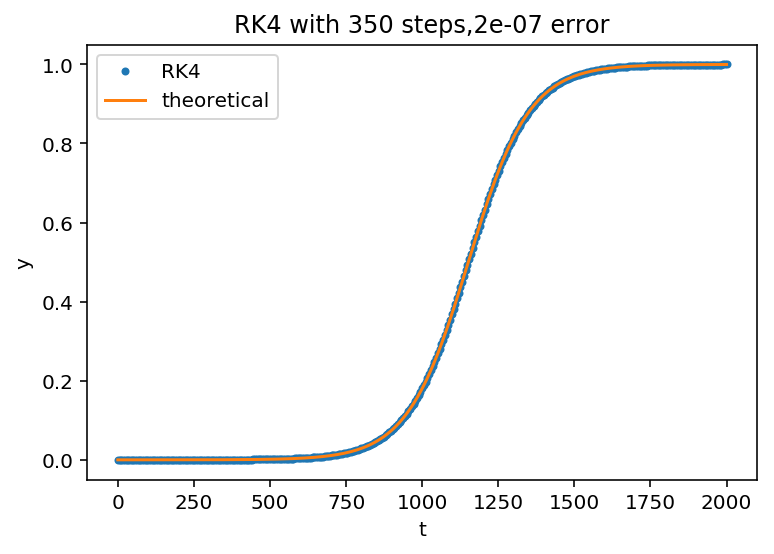

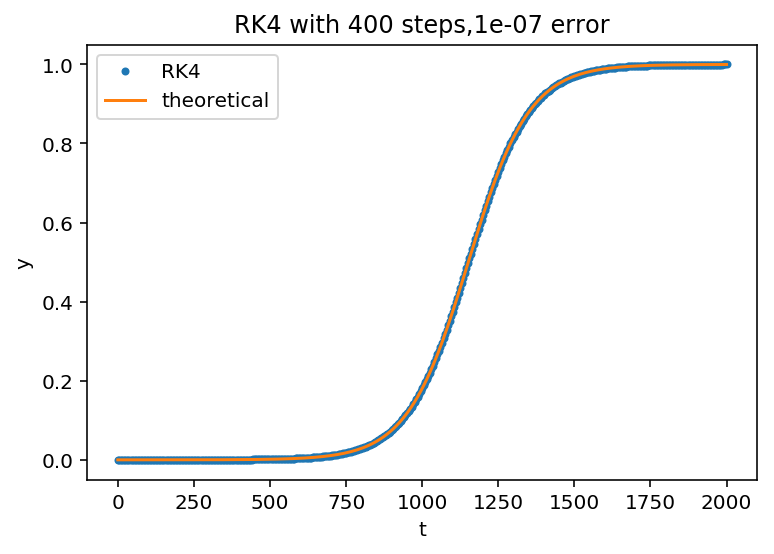

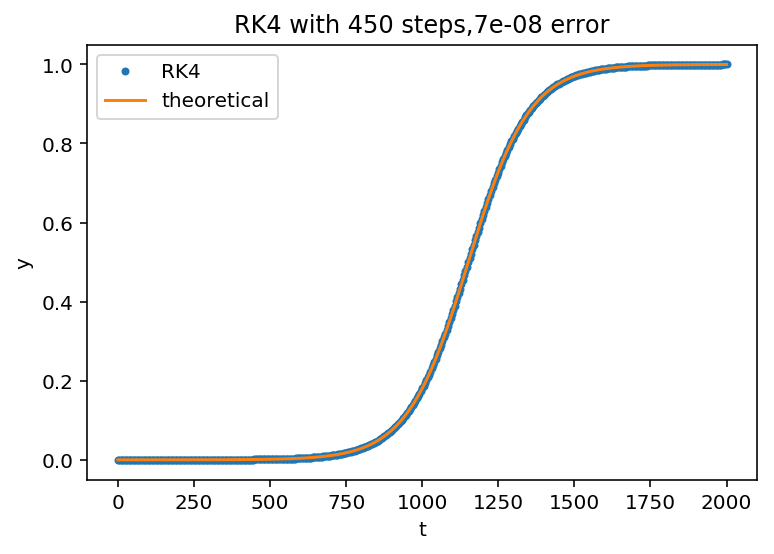

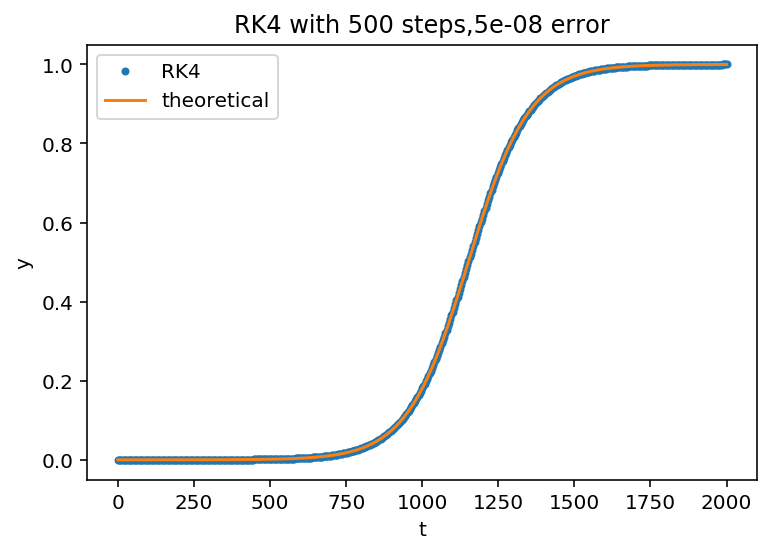

In [1]:
%config InlineBackend.figure_format = 'retina' 
from math import *
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

def rk4(f, x0, y0, x1, n):   #x0,y0 are initial values, n is no. steps 
    vx = [0] * (n + 1)       #x1 is endding point for x
    vy = [0] * (n + 1)
    h = (x1 - x0) / float(n) #stepsize
    vx[0] = x = x0
    vy[0] = y = y0
    for i in range(1, n + 1):
        k1 = h * f(x, y)
        k2 = h * f(x + 0.5 * h, y + 0.5 * k1)
        k3 = h * f(x + 0.5 * h, y + 0.5 * k2)
        k4 = h * f(x + h, y + k3)
        vx[i] = x = x0 + i * h
        vy[i] = y = y + (k1 + k2 + k2 + k3 + k3 + k4) / 6
    return vx, vy
@np.vectorize
def theo(t): #theoretical solution of y = y(t)
    return 1./(1+(1e5-1)*np.exp(-t/1e2)) 
t = np.linspace(0,2000,200)
yy = theo(t)
def f(x, y): #function of y'
    return 1e-2 * y*(1-y)
n = 10
i = 2
while i<12:
    T = np.array([])
    Y = np.array([])
    D = np.array([])
    vx, vy = rk4(f, 0, 1e-5, 2000, n)
    y_t = theo(vx)
    std = np.abs(y_t - vy)
    D = np.append(D,std)
    for x, y in list(zip(vx, vy)):
        T = np.append(T,x)
        Y = np.append(Y,y)
        

    #plot 
    plt.plot(T,Y,'.')
    plt.plot(t,yy,'-')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.title('RK4 with '+str(n)+' steps,'+str('%.e'%max(D))+' error')
    plt.legend(['RK4','theoretical'])
    plt.show()
    n = i*50
    i+=1

The above results shows that in order to reach a tolerance of $10^{-7}$, at least 400 steps are required.

### (b) Adaptive step size -- Dormand-Prince method

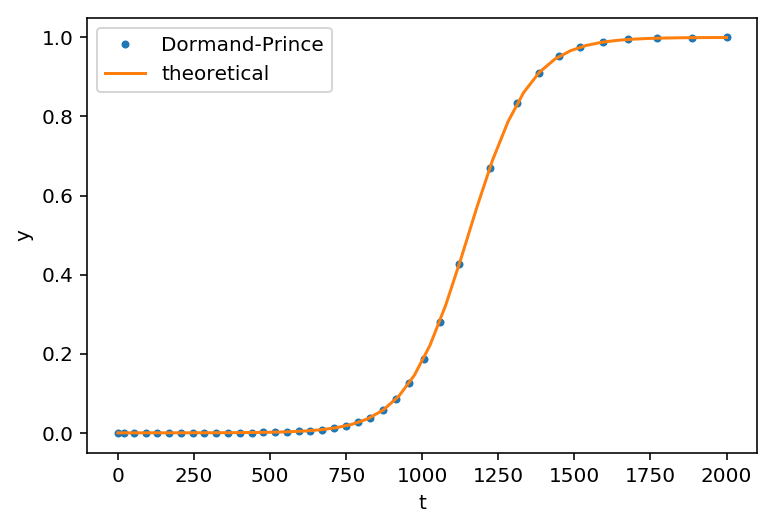

In [2]:
import warnings


t0 = 0
y0 = 1e-5
t1 = 2000.0

backend = 'dopri5'

solver = ode(f).set_integrator(backend, nsteps=1)
solver.set_initial_value(y0, t0)
# suppress Fortran-printed warning
solver._integrator.iwork[2] = -1

sol = []
warnings.filterwarnings("ignore", category=UserWarning)
while solver.t < t1:
    solver.integrate(t1,step=True)
    sol.append([solver.t, solver.y])
warnings.resetwarnings()
sol = np.array(sol)

plt.plot(sol[:,0], sol[:,1], '.')
t = np.linspace(0,2000,40)
y = theo(t)
plt.plot(t,y,'-')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Dormand-Prince','theoretical'])
plt.show()

## Problem 2 -- Coupled ODEs

\begin{align*}
y'_1(x) &= -y_1^2(x) - y_2(x)\\
y'_2(x) &= 5y_1(x) -y_2(x)
\end{align*}
with boundary initial conditions $y_1(0) = y_2(0) = 1.5$, for $0\leq x \leq 10$.

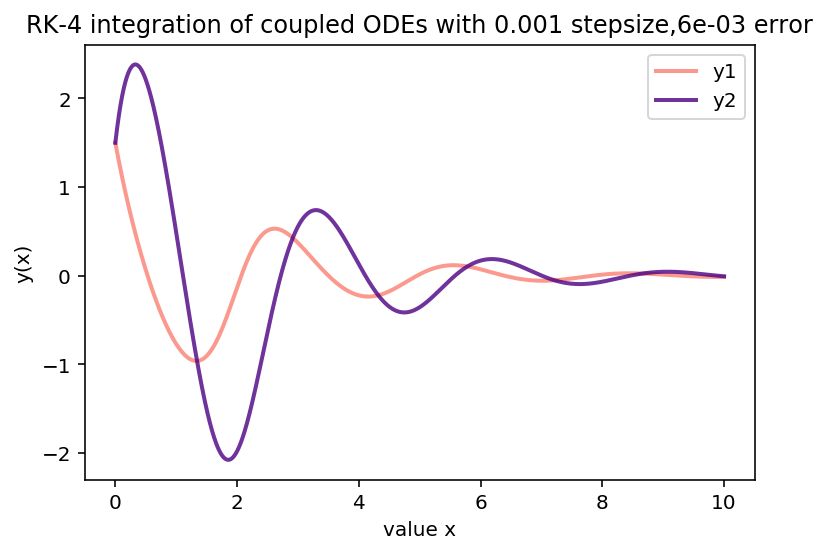

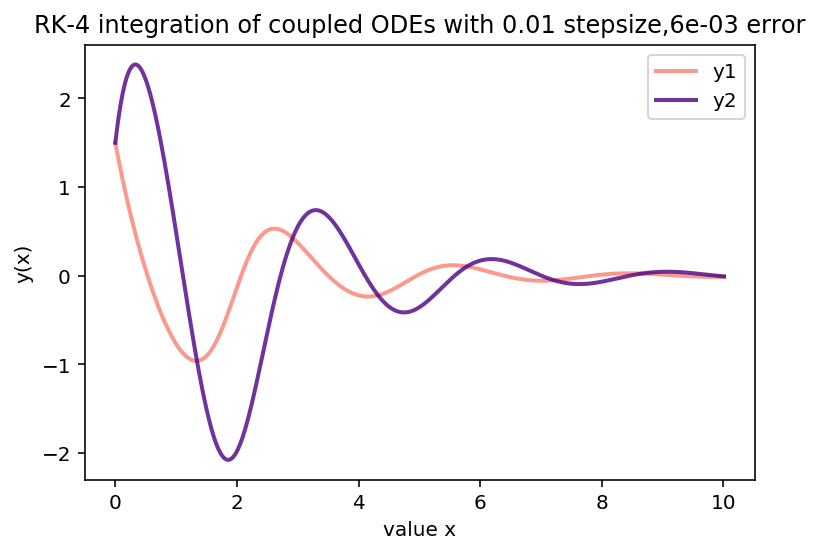

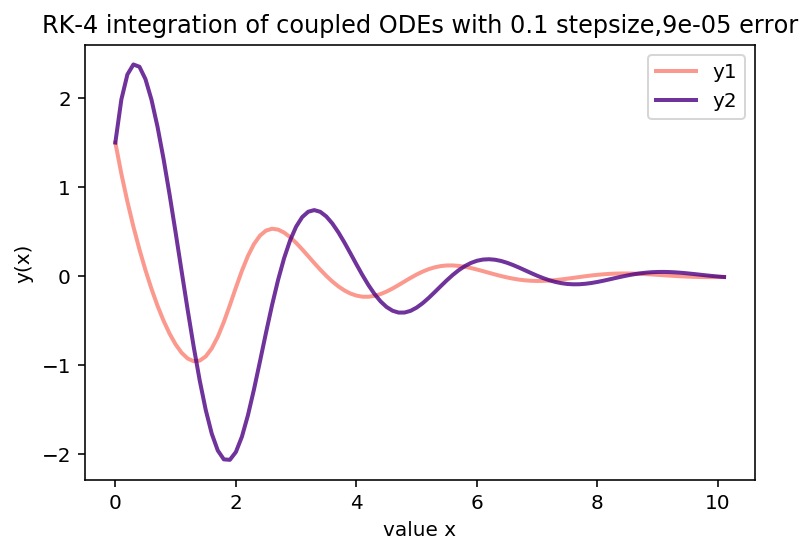

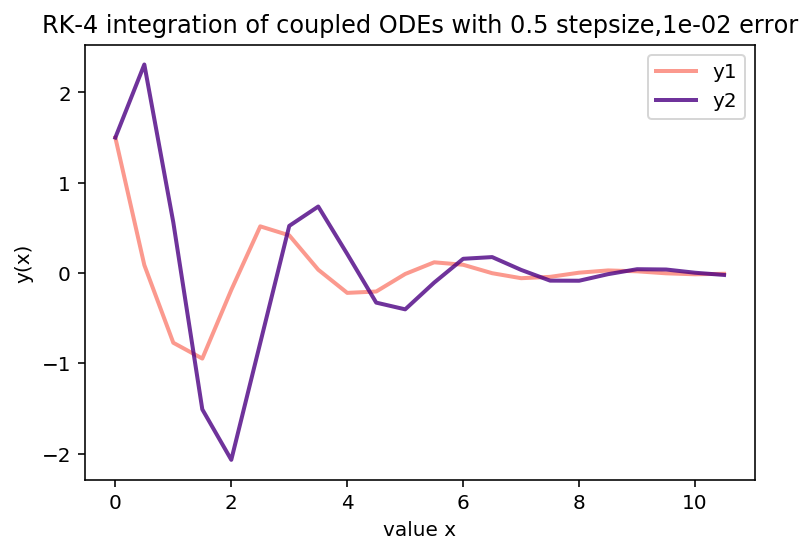

In [3]:
from matplotlib.pyplot import figure, show

def f1(y1,y2):
    return -y1**2-y2

def f2(y1,y2):
    return 5*y1-y2

def couple(h,x,y1,y2): #RK-4 method with coupled ODEs
    k1 = h*f1(y1,y2)
    j1 = h*f2(y1,y2)
    
    k2 = h*f1(y1+0.5*k1,y2+0.5*j1)
    j2 = h*f2(y1+0.5*k1,y2+0.5*j1)
    
    k3 = h*f1(y1+0.5*k2,y2+0.5*j2)
    j3 = h*f2(y1+0.5*k2,y2+0.5*j2)
    
    k4 = h*f1(y1+k3,y2+j3)
    j4 = h*f2(y1+k3,y2+j3)
    
    
    y1_next = y1 + (k1+2*k2+2*k3+k4)/6
    y2_next = y2 + (j1+2*j2+2*j3+j4)/6
    x_next = x + h
    
    return x_next,y1_next,y2_next


H = [1e-3,1e-2,0.1,0.5]
i=0
for i in range(4):
    x = 0 #initial conditions
    y1 = 1.5
    y2 = 1.5

    xarray = np.array([0]) #array to save data
    y1array = np.array([1.5])
    y2array = np.array([1.5])


    while x <= 10: #max x
        x,y1,y2 = couple(H[i],x,y1,y2) #integration process
        xarray = np.append(xarray,x)
        y1array = np.append(y1array,y1)
        y2array = np.append(y2array,y2)
        err = '%.e'% abs(y1array[-1]-y2array[-1])
        
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    frame.plot(xarray,y1array,lw = 2,alpha = 0.8,color = 'salmon')
    frame.plot(xarray,y2array,lw = 2,alpha = 0.8,color = 'indigo')
    frame.set_xlabel('value x')
    frame.set_ylabel('y(x)')
    frame.set_title('RK-4 integration of coupled ODEs with '+str(H[i])+' stepsize,'+str(err)+' error' )
    frame.legend(['y1','y2'])
    show()
    i+=1

The best choice is with stepsize 0.1.

## Problem 3 -- Leap-frog algorithm

Plummer potential
$$\Phi(r) = -GM/(r^2+b^2)^{1/2}$$
$$\mathbf{F} = -\nabla\Phi$$
\begin{align*}
dx_i/dt &= v_i & for \ i = 1..3\\
dv_i/dt &= -\Phi'(r)\frac{\partial x_i}{\partial r}=-\Phi'(r)x_i/r & for \ i=1..3
\end{align*}
and where $r = (x_1^2+x_2^2+x_3^2)^{1/2}$

In [36]:
from math import*
import scipy.constants as scc


#initial conditions
x1 = 20
x2 = 5
x3 = 0

v1 = 0
v2 = 180
v3 = 0


# Physical constants         #for simplicity the energy and momentum are 
M0 = 1.9891e30 #solar mass   #expressed in standard units * solar mass^{-1}
Gyr = 31556926e9 #Gyr
kpc = 30.9e18
G = 4.302e-6 #kpc Msun^-1 (km/s)^2  
M = 1e11
b = 10


def ac(x,r): #acceleration  #function needed for the LF-algorithm
    b = 10
    a = G*M*x/(r**2+b**2)**1.5
    return -a

t = 0
dt = 1e-4 # a timestep of 1e-4 Gyr

r1 = (x1**2+x2**2+x3**2)**0.5

v1mid = v1 + 0.5*dt*ac(x1,r1) #find corresponding mid point velocity
v2mid = v2 + 0.5*dt*ac(x2,r1) #initial conditions given at the same time
v3mid = v3 + 0.5*dt*ac(x3,r1) #needs to make a jump start
x1array = np.array([20])
x2array = np.array([5])
x3array = np.array([0])

v1array = np.array([v1mid])
v2array = np.array([v2mid])
v3array = np.array([v3mid])

radius = np.array([r1])
time = np.array([0])

L = np.array([])
Energy = np.array([])
print "A proof of conservation of energy and momentum"
print('t (Gyr) | E (kpc (km/s)^2)  |      L (Msun kpc^2 / Gyr)')
print('-' * 55)

while t<= 2.: #leap frog method
    x1 = x1 + v1mid*dt
    x2 = x2 + v2mid*dt
    x3 = x3 + v3mid*dt
    
    r = (x1**2+x2**2+x3**2)**0.5
    
    a1 = ac(x1,r)
    a2 = ac(x2,r)
    a3 = ac(x3,r)
    
    v1mid = v1mid + dt*a1
    v2mid = v2mid + dt*a2
    v3mid = v3mid + dt*a3
    
    t = t + dt
    
    x1array = np.append(x1array,x1)
    x2array = np.append(x2array,x2)
    x3array = np.append(x3array,x3)

    v1array = np.append(v1array,v1mid)
    v2array = np.append(v2array,v2mid)
    v3array = np.append(v3array,v3mid)
    
    radius = np.append(radius,r)
    time = np.append(time,t)
    
    if round(t,4)%.25 == 0:                  #for every 0.25Gyr position check 
        # in energy per solar mass unit       #if angular momentum and energy 
        v = (v1mid**2+v2mid**2+v3mid**2)**0.5 #are conserved
        L = np.append(L,x1*v2mid-x2*v1mid) #cross product in Z direction
        e = 0.5*v**2-G*M/(r**2+b**2)**0.5
        Energy = np.append(Energy,e)
        print'  {:.2f}  |      {:.1f}      |     {}'.format(t, e, x1*v2mid-x2*v1mid)

A proof of conservation of energy and momentum
t (Gyr) | E (kpc (km/s)^2)  |      L (Msun kpc^2 / Gyr)
-------------------------------------------------------
  0.25  |      -2576.5      |     3600.0
  0.50  |      -2575.9      |     3600.0
  0.75  |      -2575.7      |     3600.0
  1.00  |      -2575.6      |     3600.0
  1.25  |      -2575.6      |     3600.0
  1.50  |      -2575.5      |     3600.0
  1.75  |      -2575.5      |     3600.0
  2.00  |      -2575.5      |     3600.0


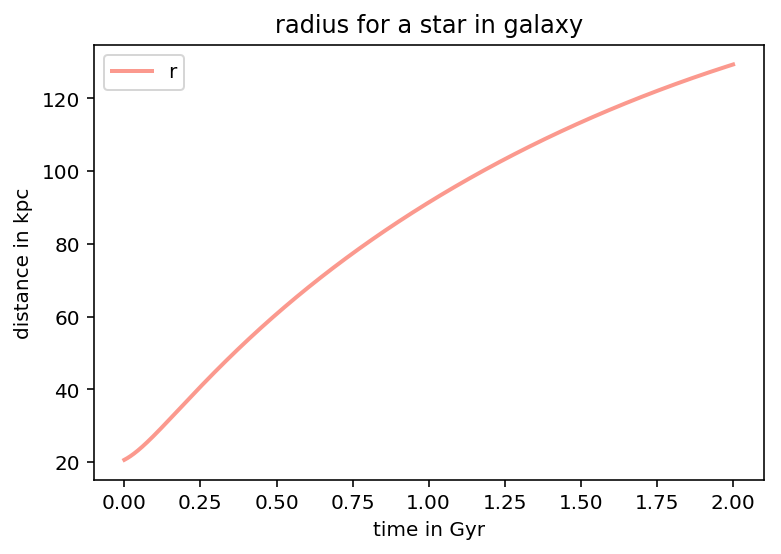

In [37]:
fig = figure()
frame = fig.add_subplot(1,1,1)

frame.plot(time,radius,linewidth = 2,alpha = 0.8,color = 'salmon')

frame.set_xlabel('time in Gyr')
frame.set_ylabel('distance in kpc')
frame.set_title('radius for a star in galaxy' )
frame.legend(['r'],loc = 2)
#frame.set_xlim(-0.5,2.5)
show()

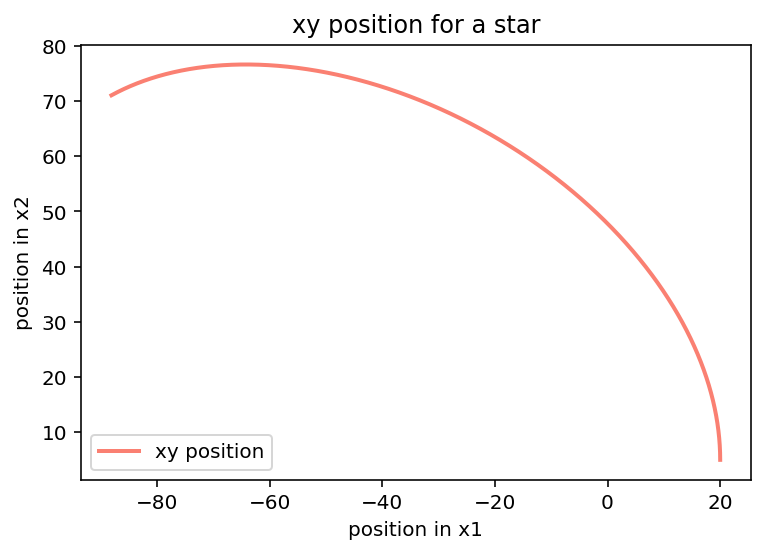

In [18]:
fig = figure()
frame = fig.add_subplot(1,1,1)

frame.plot(x1array,x2array,alpha = 1,linewidth = 2,color = 'salmon')

frame.set_xlabel('position in x1')
frame.set_ylabel('position in x2')
frame.set_title('xy position for a star' )
frame.legend(['xy position'],loc = 3)
show()


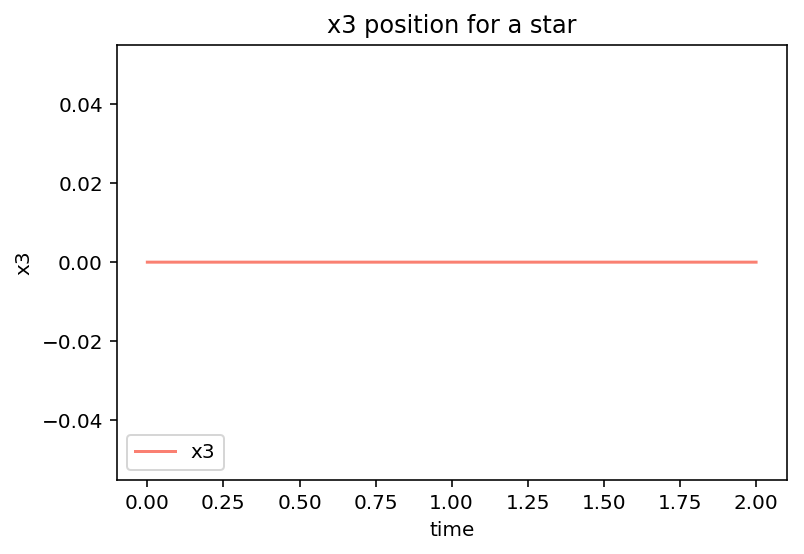

In [21]:
fig = figure()
frame = fig.add_subplot(1,1,1)

frame.plot(time,x3array,alpha = 1,color='salmon')
frame.set_xlabel('time')
frame.set_ylabel('x3')
frame.set_title('x3 position for a star' )
frame.legend(['x3'],loc = 3)
show()

Beacause of conservation of energy and angular momentum, no movement is in z-direction. This suggests that the galaxy can be approximated by a flat disk.